PyDESeq2

In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc

import plotnine as p9

import liana as li
import decoupler as dc
# import omnipath as op

# Import DESeq2
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

from matplotlib import pyplot as plt


In [2]:
net = dc.get_collectri(organism='human')

/home/dbdimitrov/miniconda3/envs/spiana/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [52]:
# net.to_csv('atts/collectri_human.csv')
net.to_csv(os.path.join("..", "..", "figures", "source", "TFtargetPK.csv"))

AnnData

In [3]:
adata = sc.read_h5ad(os.path.join('results', 'kuppe_processed.h5ad'))

In [4]:
sample_key = 'sample'
condition_key = 'patient_group'
groupby = 'cell_type_original'

In [5]:
resource = pd.read_csv(os.path.join('results', 'lr_pairs.csv'))
cell_pairs = pd.read_csv(os.path.join('results', 'cell_pairs.csv'))

In [6]:
resource = resource[resource['top1std']]

Create Pseudobulk

In [7]:
pdata = dc.get_pseudobulk(
    adata,
    sample_col=sample_key,
    groups_col=groupby,
    layer='counts',
    mode='sum',
    min_cells=10,
    min_counts=10000,
    min_smpls=3
)
pdata

AnnData object with n_obs × n_vars = 273 × 26972
    obs: 'sample', 'cell_type_original', 'patient_region_id', 'donor_id', 'patient_group', 'major_labl', 'assay_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'psbulk_n_cells', 'psbulk_counts'
    var: 'feature_name', 'feature_reference', 'feature_biotype', 'n_cells'
    layers: 'psbulk_props'

In [8]:
pdata.obs = pdata.obs[[sample_key, groupby, condition_key, "patient_region_id", "major_labl", "cell_type", "psbulk_n_cells", "psbulk_counts"]]

In [9]:
pdata.write_h5ad(os.path.join('results', 'kuppe_pseudobulk.h5ad'))

... storing 'sample' as categorical
... storing 'cell_type_original' as categorical
... storing 'patient_group' as categorical
... storing 'patient_region_id' as categorical
... storing 'major_labl' as categorical
... storing 'cell_type' as categorical


Normalize

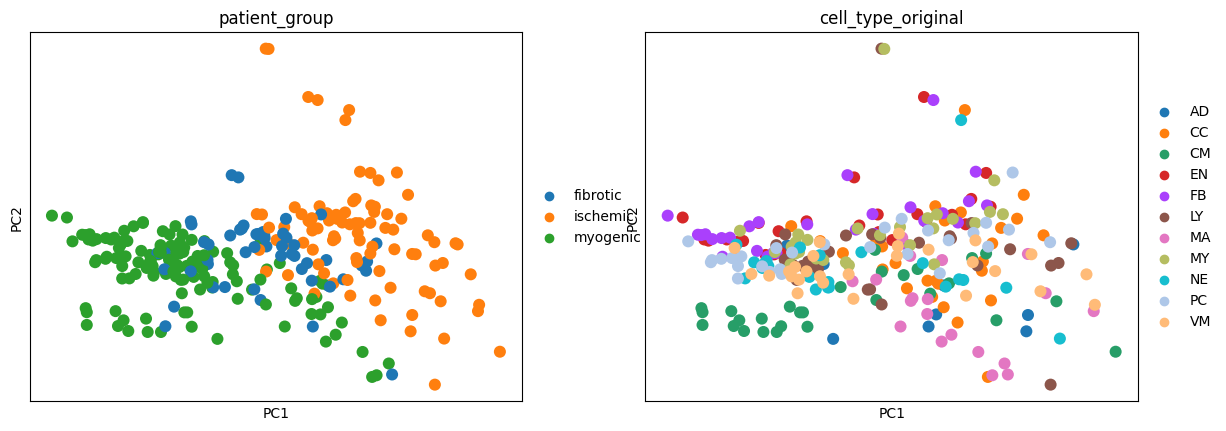

In [10]:
pp_pdata = pdata.copy()
sc.pp.normalize_total(pp_pdata, target_sum=1e6)
sc.pp.log1p(pp_pdata)
sc.pp.scale(pp_pdata, max_value=10)
sc.tl.pca(pp_pdata, n_comps=10)

sc.pl.pca(pp_pdata, color=[condition_key, groupby], ncols=2, show=True, size=300)

In [11]:
dc.get_metadata_associations(
    pp_pdata,
    obs_keys = [groupby, condition_key], #metadata columns to associate to PCs
    obsm_key='X_pca',  # where the PCs are stored
    uns_key='pca_anova',  # where the results are stored
    inplace=True
)



<Figure size 700x1000 with 0 Axes>

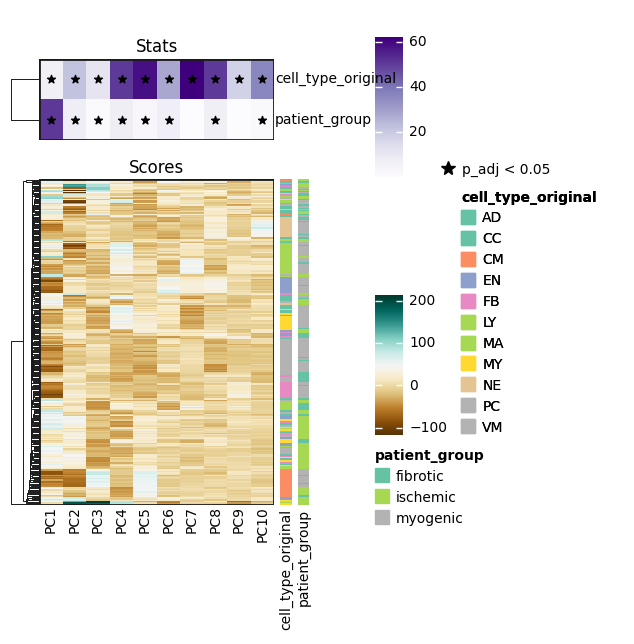

In [12]:
plt.figure(figsize=(7,10))
dc.plot_associations(
    pp_pdata,
    uns_key='pca_anova',  # summary statistics from the anova tests
    obsm_key='X_pca',  # where the PCs are stored
    stat_col='p_adj',  # which summary statistic to plot
    obs_annotation_cols = [groupby, condition_key], # which sample annotations to plot
)
plt.show()

In [13]:
pdata.obs['condition'] = 'Rest'
pdata.obs.loc[pdata.obs[condition_key]=='ischemic', 'condition'] = 'IZ'

In [14]:
condition_key = 'condition'
ref = "Rest"
cond = "IZ"

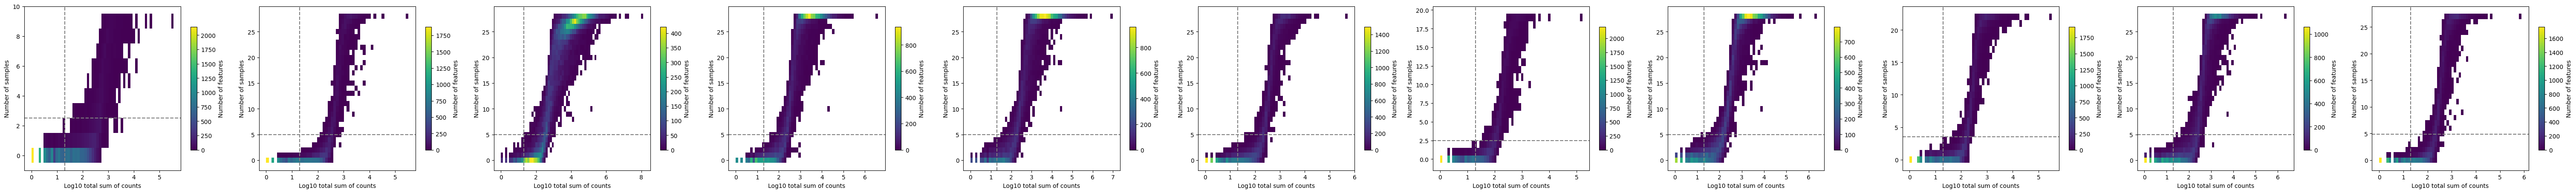

In [15]:
min_count = 10
min_total_count = 20
large_n = 5
min_prop = 0.1

# plt with ax with same number as groups
fig, axes = plt.subplots(1, len(pdata.obs[groupby].unique()), figsize=(7*len(pdata.obs[groupby].unique()), 5))

for i, cell_group in enumerate(pdata.obs[groupby].unique()):
    ctdata = pdata[pdata.obs[groupby] == cell_group].copy()
    dc.plot_filter_by_expr(ctdata, group=condition_key, min_count=min_count, min_total_count=min_total_count, large_n=large_n, min_prop=min_prop, ax =axes[i])

In [16]:
%%capture
dea_results = {}

for cell_group in pdata.obs[groupby].unique():
    # Select cell profiles
    ctdata = pdata[pdata.obs[groupby] == cell_group].copy()
    dc.plot_filter_by_expr(ctdata, group=condition_key, min_count=min_count, min_total_count=min_total_count, large_n=large_n)

    # Obtain genes that pass the edgeR-like thresholds
    # NOTE: QC thresholds might differ between cell types, consider applying them by cell type
    genes = dc.filter_by_expr(ctdata,
                              group=condition_key,
                              min_count=min_count,
                              min_total_count=min_total_count,
                              large_n=large_n,
                              min_prop=min_prop
                              )

    # Filter by these genes
    ctdata = ctdata[:, genes].copy()

    # Build DESeq2 object
    dds = DeseqDataSet(
        adata=ctdata,
        design_factors=condition_key,
        ref_level=[condition_key, 'Rest'],
        refit_cooks=True,
    )

    # Compute LFCs
    dds.deseq2()
    # Contrast between stim and ctrl
    stat_res = DeseqStats(dds, contrast=[condition_key, cond, ref])
    # Compute Wald test
    stat_res.summary()
    # Shrink LFCs
    stat_res.lfc_shrink(coeff=f'{condition_key}_{cond}_vs_{ref}') # {condition_key}_cond_vs_ref

    dea_results[cell_group] = stat_res.results_df

In [17]:
# concat results across cell types
dea_df = pd.concat(dea_results)
dea_df = dea_df.reset_index().rename(columns={'level_0': groupby})
dea_df.set_index('feature_name', inplace=True)
dea_df.to_csv(os.path.join('results', 'dea.csv'))

In [18]:
dea_df.head()

,cell_type_original,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
feature_name,,,,,,,
AACS,AD,14.042497,-0.111642,0.338404,-2.115041,0.034426,0.423011
AAK1,AD,28.884569,-0.013613,0.313339,-0.131298,0.895539,0.975265
AASS,AD,31.960581,-0.078546,0.332381,-1.132539,0.257408,0.717119
ABCA1,AD,28.841675,0.024811,0.334241,0.264935,0.791059,0.961225
ABCA5,AD,14.516484,-0.079954,0.330428,-0.941864,0.346263,0.784765


Read DEA Results

In [19]:
dea_df = pd.read_csv(os.path.join('results', 'dea.csv'), index_col=0)

In [20]:
# keep only iz
adata_s = adata[adata.obs['patient_group']=='ischemic', :] # change to condition key when in adata

In [21]:
sc.pp.normalize_total(adata_s)
sc.pp.log1p(adata_s)
# NOTE: it's not already log-transformed (its something with the way it's saved)

/home/dbdimitrov/miniconda3/envs/spiana/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.


In [22]:
resource = resource[resource['top5']][['ligand', 'receptor']] # NOTE some bug when I dont subselect the columns

In [23]:
lr_res = li.multi.df_to_lr(adata_s,
                           dea_df=dea_df,
                           resource=resource,
                           expr_prop=0.05, # calculated for adata as passed - used to filter interactions
                           groupby=groupby,
                           stat_keys=['stat', 'padj', 'log2FoldChange'],
                           use_raw=False,
                           complex_col='props',
                           verbose=True,
                           return_all_lrs=False,
                           groupby_pairs=cell_pairs,
                           )

Using `.X`!
/home/dbdimitrov/miniconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/anndata.py:864: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['CSTF2T', 'ALDH1A2', 'SNRPG', 'ACADSB', 'LILRA6']

    Inferred to be: categorical

3906 features of mat are empty, they will be removed.


Using provided `resource`.


/home/dbdimitrov/miniconda3/envs/spiana/lib/python3.10/site-packages/liana/method/_pipe_utils/_pre.py:148: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
['RMRP_ENSG00000269900', 'ALG1L9P_ENSG00000248671', 'RP11-436O19__A.6', 'LINC01830_ENSG00000234207', 'LINC00486_ENSG00000230876', 'SLFN12L_ENSG00000205045', 'POLR2J3_ENSG00000285437', 'SIGLEC5_ENSG00000105501', 'DNAJC9-AS1_ENSG00000227540', 'ITFG2-AS1_ENSG00000258325', 'FAM153B_ENSG00000182230', 'RAET1E-AS1_ENSG00000268592', 'PINX1_ENSG00000254093', 'ELFN2_ENSG00000243902', 'SPATA13_ENSG00000182957', 'DUXAP8_ENSG00000206195', 'DGCR5_ENSG00000273032', 'RP4-633O19__A.1', 'LINC00941_ENSG00000285517', 'DNAJC9-AS1_ENSG00000236756', 'LINC00486_ENSG00000236854', 'RNU11_ENSG00000270103', 'CLCA4-AS1_ENSG00000236915', 'RP11-99J16__A.2', 'LINC01115_ENSG00000237667', 'LINC01605_ENSG00000253161', 'XXyac-YX65C7_A.2', 'LINC01830_ENSG00000228999', 'RPPH1_ENSG00000259001', 'PRICKLE2-AS1_ENSG0000024

In [49]:
lr_res.to_csv(os.path.join('results', 'dea_interactions.csv'), index=False)
lr_res.to_csv(os.path.join('..', '..', 'figures', 'source', 'SuppDataFig3_deaLRs.csv'))

Pick interactions of interst based on R2

/home/dbdimitrov/miniconda3/envs/spiana/lib/python3.10/site-packages/plotnine/scales/scale.py:143: PlotnineWarning: scale_color_cmap could not recognise parameter `midpoint`
/home/dbdimitrov/miniconda3/envs/spiana/lib/python3.10/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'color' is already present.
Adding another scale for 'color',
which will replace the existing scale.



Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


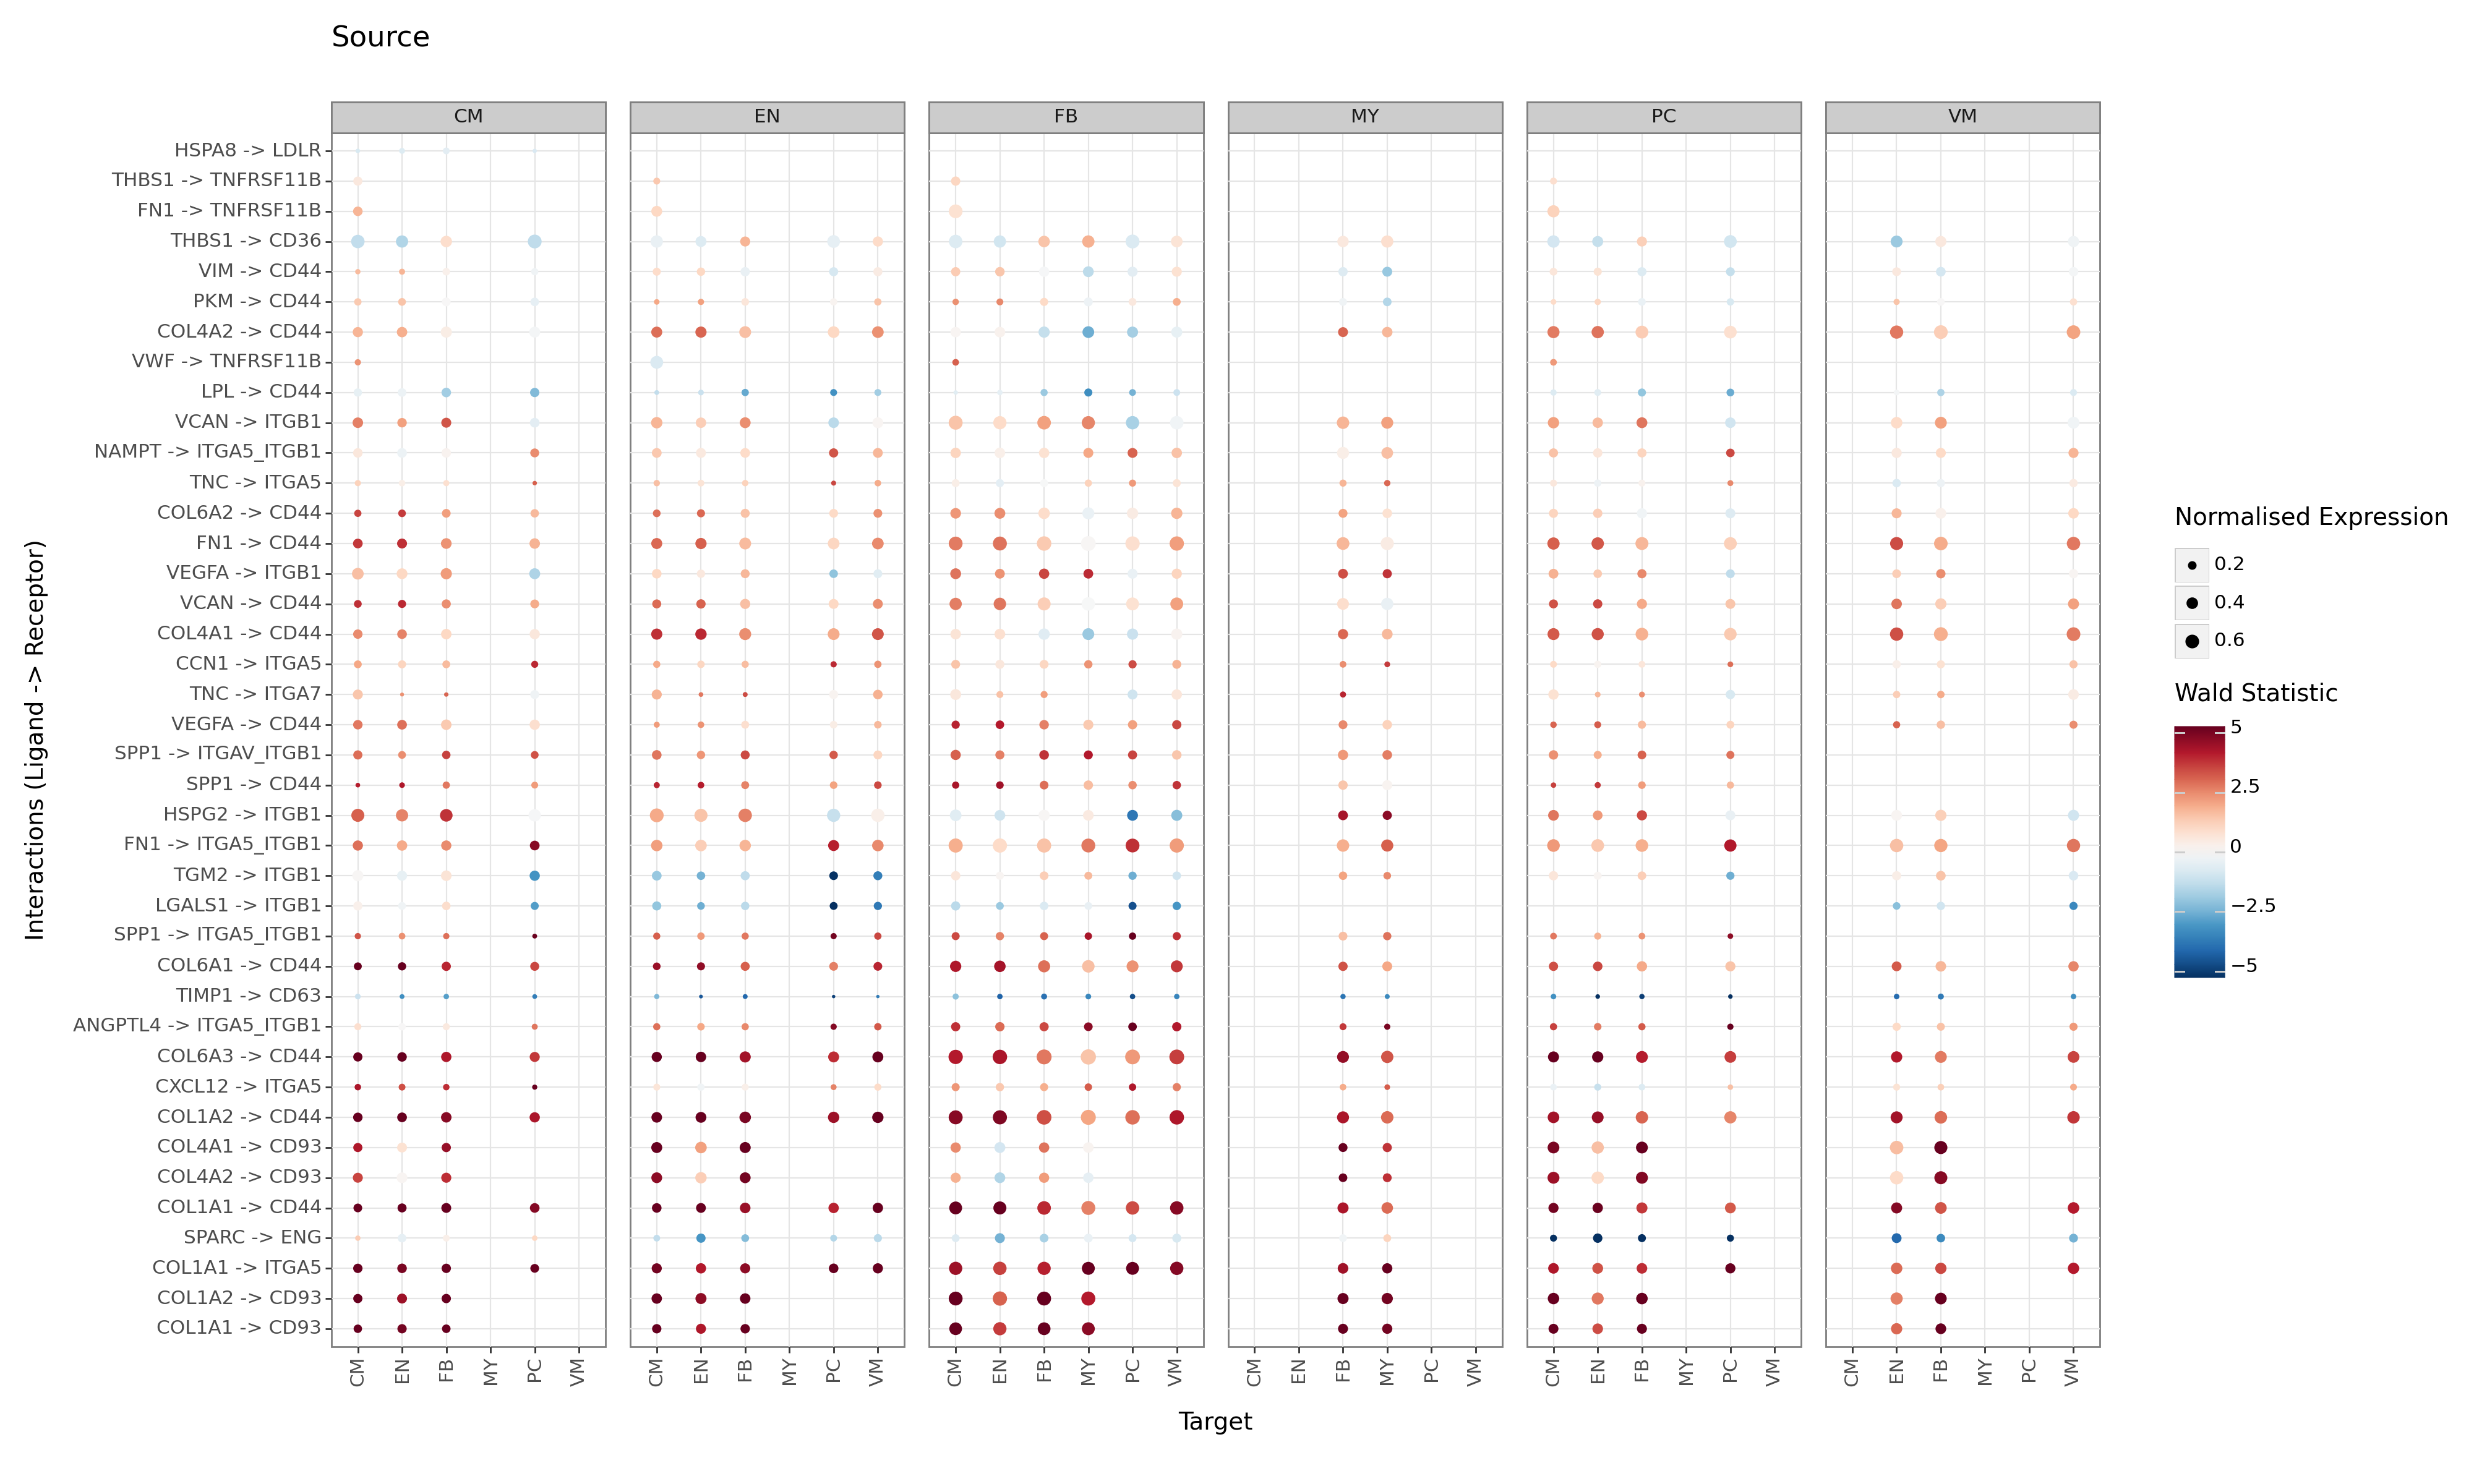

<Figure Size: (2000 x 1200)>

In [25]:
plot = li.pl.dotplot(liana_res=lr_res,
                     colour='interaction_stat',
                     size='interaction_expr',
                     inverse_size=False,
                     orderby='interaction_stat',
                     orderby_ascending=False,
                     orderby_absolute=True,
                     top_n=60,
                     size_range=(0.1, 4),
                     figure_size=(20, 12)
                     )

# customize plot
(
    plot
    + p9.theme_bw(base_size=14)
    # fill cmap blue to red, + limits for colour and mid point
    + p9.scale_color_cmap('RdBu_r', limits=(-5, 5), midpoint=0)
    # rotate x
    + p9.theme(axis_text_x=p9.element_text(angle=90), figure_size=(20, 12)) +
    p9.labs(color='Wald Statistic', size='Normalised Expression')
)

In [26]:
lr_res.head() # NOTE move target next to source

,ligand,receptor,ligand_complex,receptor_complex,source,ligand_props,ligand_stat,ligand_padj,ligand_log2FoldChange,ligand_expr,...,receptor_stat,receptor_padj,receptor_log2FoldChange,receptor_expr,interaction_props,interaction_stat,interaction_padj,interaction_log2FoldChange,interaction_expr,interaction
0,FN1,TNFRSF11B,FN1,TNFRSF11B,CM,0.496636,4.354609,6.845032e-05,1.988196,0.449801,...,-0.949650,0.427846,-0.396765,0.053863,0.285849,1.702480,0.213957,0.795716,0.251832,FN1^TNFRSF11B
1,VWF,TNFRSF11B,VWF,TNFRSF11B,CM,0.181034,5.421287,6.308562e-07,1.749170,0.150543,...,-0.949650,0.427846,-0.396765,0.053863,0.128049,2.235818,0.213923,0.676203,0.102203,VWF^TNFRSF11B
2,THBS1,TNFRSF11B,THBS1,TNFRSF11B,CM,0.431876,1.966947,8.482327e-02,0.834203,0.401172,...,-0.949650,0.427846,-0.396765,0.053863,0.253469,0.508648,0.256335,0.218719,0.227517,THBS1^TNFRSF11B
3,HSPA8,LDLR,HSPA8,LDLR,CM,0.061186,-3.291086,2.973849e-03,-1.010803,0.044216,...,1.665407,0.148992,0.763257,0.087906,0.087363,-0.812840,0.075983,-0.123773,0.066061,HSPA8^LDLR
4,ANGPTL4,ITGA5,ANGPTL4,ITGA5_ITGB1,CM,0.138982,0.571207,6.451888e-01,0.228651,0.112425,...,1.115828,0.346674,0.409694,0.142970,0.167578,0.843518,0.495931,0.319172,0.127697,ANGPTL4^ITGA5_ITGB1


In [27]:
# cap at 5
max_value = 4
lr_res['ligand_stat'] = lr_res['ligand_stat'].apply(lambda x: max_value if x > max_value else x)
lr_res['ligand_stat'] = lr_res['ligand_stat'].apply(lambda x: -max_value if x < -max_value else x)

lr_res['receptor_stat'] = lr_res['receptor_stat'].apply(lambda x: max_value if x > max_value else x)
lr_res['receptor_stat'] = lr_res['receptor_stat'].apply(lambda x: -max_value if x < -max_value else x)

In [28]:

plot = (li.pl.tileplot(liana_res=lr_res,
                       fill = 'log2FoldChange',
                       label='padj',
                       source_labels=['MY', 'FB'], # , 'Mast', "Cardiomyocyte", 'Lymphoid'
                       target_labels=['MY', 'FB'], # Cardiomyocyte, 'Vascular_SMCs'
                       ligand_complex=["FN1", 'TNC', 'THBS1', 'SPP1'], # , 'NAMPT'
                #        receptor_complex=["ERBB3", "ERBB2_ERBB3", "EGFR_ERBB2", "EGFR"],
                       label_fun = lambda x: '*' if x < 0.05 else np.nan,
                       source_title='Ligand',
                       target_title='Receptor',
                       cmap='coolwarm',
                       figure_size=(7.3, 6),
                       label_size=25,
                       ) +
        p9.labs(fill='log2FC\n\n')
)
# cbar range between -4 and 4
plot += p9.scale_fill_gradient2(limits=(-3.5, 3.5), midpoint=0, low='#1f77b4', mid='lightgray', high='#c20019')
# adjust text
plot += p9.theme(legend_text=p9.element_text(size=20),
                 legend_title=p9.element_text(size=20),
                 strip_text=p9.element_text(size=20),
                 axis_text=p9.element_text(size=20),
                 axis_title_x=p9.element_text(size=20),
                 axis_title_y=p9.element_blank())

plot.save(os.path.join('..', '..', 'figures', 'Fig3L.pdf'), dpi=300)

/home/dbdimitrov/miniconda3/envs/spiana/lib/python3.10/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'fill' is already present.
Adding another scale for 'fill',
which will replace the existing scale.

/home/dbdimitrov/miniconda3/envs/spiana/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 7.3 x 6 in image.
/home/dbdimitrov/miniconda3/envs/spiana/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../../figures/Fig3L.pdf
/home/dbdimitrov/miniconda3/envs/spiana/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_text : Removed 21 rows containing missing values.
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


/home/dbdimitrov/miniconda3/envs/spiana/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_text : Removed 21 rows containing missing values.
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


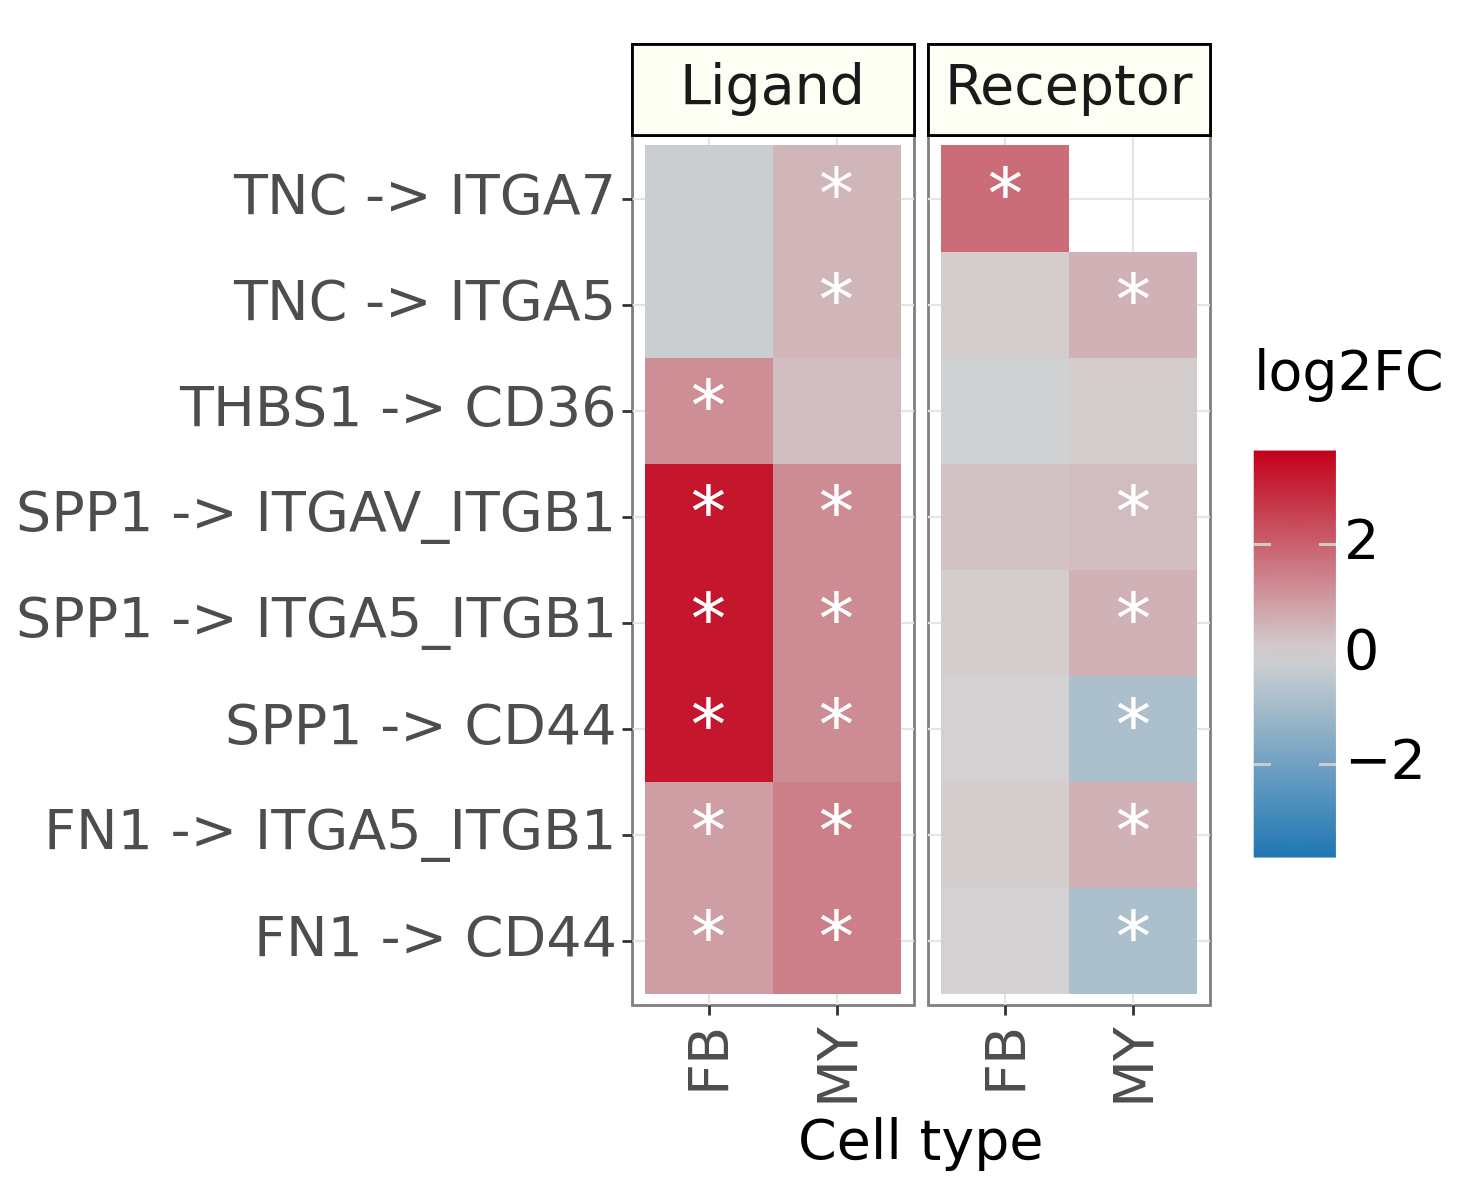

<Figure Size: (730 x 600)>

In [29]:
plot

TFs

In [30]:
from decoupler import p_adjust_fdr

In [31]:
acts = {}

for cell_group in pdata.obs[groupby].unique():
    ct_df = dea_df[dea_df[groupby] == cell_group].copy()
    mat = ct_df[['stat']].T.rename(index={'stat': cell_group})
    
    # Infer pathway activities with ulm
    tf_acts, tf_pvals = dc.run_ulm(mat=mat, net=net)
    tf_acts = tf_acts.T.rename(columns={cell_group: 'activity'})
    tf_pvals = tf_pvals.T.rename(columns={cell_group: 'pvalue'})
    
    act = tf_acts.merge(tf_pvals, left_index=True, right_index=True)
    acts[cell_group] = act
    

In [32]:
acts = pd.concat(acts)

In [33]:
acts['fdr'] = p_adjust_fdr(acts['pvalue'])
acts = acts.reset_index(names=[groupby, 'tf'])

In [34]:
acts.to_csv(os.path.join('results', 'tf_activities.csv'), index=False)

In [35]:
# group number of tf by cell type that are with fdr < 0.05
acts[acts['fdr'] < 0.05].groupby(groupby).size()

cell_type_original
AD     4
CC     3
CM    78
EN     9
FB    38
LY     5
MA    18
MY    11
NE     2
PC     5
VM     4
dtype: int64

We target myeloid because both the receptor and SPP1 & NAMPT1 are up - also unlikely to be noise

In [36]:
target = 'MY'

In [37]:
lr_res[(lr_res['target']==target) &
       (lr_res['source']==target) &
       (lr_res['ligand'].str.contains('FN1|NAMPT|SPP1')) & 
       (lr_res['receptor_complex'].str.contains('ITGB1')) & 
       (lr_res['ligand_padj'] < 0.05)].sort_values("interaction_stat")

,ligand,receptor,ligand_complex,receptor_complex,source,ligand_props,ligand_stat,ligand_padj,ligand_log2FoldChange,ligand_expr,...,receptor_stat,receptor_padj,receptor_log2FoldChange,receptor_expr,interaction_props,interaction_stat,interaction_padj,interaction_log2FoldChange,interaction_expr,interaction
1131,SPP1,ITGB1,SPP1,ITGAV_ITGB1,MY,0.229742,2.647773,0.018546,1.188269,0.277140,...,2.486163,0.027661,0.367719,0.244263,0.219692,2.566968,0.023104,0.777994,0.260702,SPP1^ITGAV_ITGB1
1133,SPP1,ITGA5,SPP1,ITGA5_ITGB1,MY,0.229742,2.647773,0.018546,1.188269,0.277140,...,2.762979,0.013786,0.550657,0.089296,0.153580,2.705376,0.016166,0.869463,0.183218,SPP1^ITGA5_ITGB1
1154,FN1,ITGA5,FN1,ITGA5_ITGB1,MY,0.608197,3.238260,0.003588,1.376954,0.808223,...,2.762979,0.013786,0.550657,0.089296,0.342808,3.000619,0.008687,0.963806,0.448759,FN1^ITGA5_ITGB1


In [38]:
acts[(acts['cell_type_original']==target) & (acts['fdr'] < 0.05)][['tf', 'activity']].to_csv(os.path.join('results', 'myeloid_tf_activities.csv'), index=False)

In [39]:
myeloids = adata_s[adata_s.obs['cell_type_original']==target, :].copy()

TODO: Deal with complex proportions per cluster, not by sample

In [40]:
myeloids

AnnData object with n_obs × n_vars = 6368 × 26972
    obs: 'sample', 'n_counts', 'n_genes', 'percent_mito', 'doublet_score', 'dissociation_score', 'cell_type_original', 'patient_region_id', 'donor_id', 'patient_group', 'major_labl', 'final_cluster', 'assay_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    var: 'feature_name', 'feature_reference', 'feature_biotype', 'n_cells'
    uns: 'X_approximate_distribution', 'batch_condition', 'cell_type_colors', 'cell_type_original_colors', 'default_embedding', 'liana_res', 'log1p', 'schema_version', 'title'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    layers: 'counts'

In [41]:
node_weights = pd.DataFrame({'props':myeloids.X.getnnz(axis=0) / myeloids.shape[0]}, index=myeloids.var_names)

In [42]:
node_weights =  pd.concat([node_weights, pd.DataFrame({'props':0.2}, index=['ITGA5_ITGB1'])])


In [43]:
node_weights.to_csv(os.path.join('results', 'myeloid_node_weights.csv'))

#### Count # FB -> MY interactions

In [44]:
lr_res = pd.read_csv(os.path.join('results', 'dea_interactions.csv'),index_col=0)
gt = lr_res[(lr_res['source']=='FB') & (lr_res['target']=='MY') & ((lr_res['ligand_padj'] < 0.05) | (lr_res['receptor_padj'] < 0.05))]

In [45]:
gt.to_csv("results/gt_lrs.csv")

In [46]:
gt.shape[0]

33